In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import big_model, aflare, calculate_specific_flare_flux
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63


In [4]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [5]:
lcs.columns.values

array(['ID', 'QCS', 'typ', 'cadence_min', 'mission', 'prefix', 'origin',
       'h_mission', 'SpT', 'view_start', 'view_stop', 'view_min',
       'view_max', 'BJDoff', 'tstart', 'ampl_min', 'ampl_max', 'RA',
       'Dec', 'J', 'R', 'Gaia_G', 'vsini_kms', 'e_vsini_kms', 'Prot_d',
       'sini', 'Ref', 'identifier', 'Rstar', 'ED', 'e_ED', 't0', 'e_t0',
       'dur', 'e_dur', 'ampl', 'e_ampl', 'Prot', 'idtyp', 'id', 'st',
       'desig_2mass', 'dist', 'dist_err', 'dist_source', 'rad', 'tflux',
       'tlum', 'kflux', 'klum', 'gmag', 'jmag', 'kmag'], dtype=object)

In [6]:
lcs = get_incl(lcs)
target = lcs.iloc[2]
target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                         14.4
e_vsini_kms                        2.6
Prot_d                         0.35125
sini                     

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.431534500702735 h
Relative amplitude of modulation: -1.3e-02


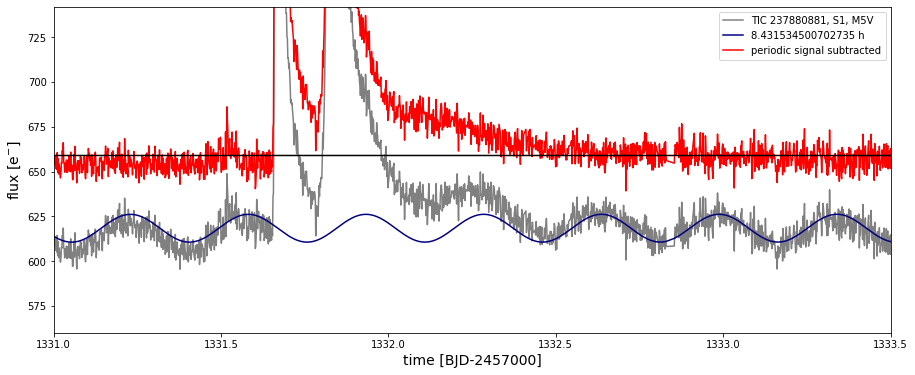

In [7]:
flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)

choice = (t > target.view_start + .76) & (t < target.view_stop-.5)
t = t[choice]
flux = sflux[choice]
flux_err = np.mean(flck.flux_err)

((834,),
 (834,),
 5.800927,
 <Quantity 8.8706892e+30 erg / s>,
 <Quantity 9.0616286e+10 erg / (cm2 s)>,
 <Quantity 1.91422551e+08 m>,
 616.9446,
 0.3718561470554695,
 0.07041668189502165,
 22.161783619143403)

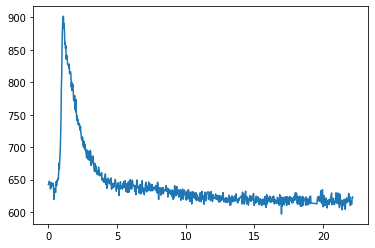

In [8]:
phi = (t - t[0])/target.Prot_d * 2 * np.pi
phi_a = (target.t0 - t[0])/target.Prot_d * 2 * np.pi
theta_a = 35*np.pi/180
a = target.ampl
fwhm = target.dur /target.Prot_d * 2 * np.pi
i_mu = target.incl
i_sigma = target.incl_err
#phi = np.linspace(0, 30*np.pi, N)
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
median = np.nanmedian(flck.flux)
phi0 = 15 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
# m = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
#               phi=phi, num_pts=50, qlum=qlum,
#               Fth=Fth, R=R, median=median)
# flare = aflare(phi, phi_a, fwhm, a*median,)
phi_a_max = phi[-1]
plt.plot(phi,flux)
phi.shape, flux.shape, flux_err, qlum, Fth, R, median, i_mu, i_sigma, phi_a_max

In [10]:
pd.DataFrame({"phi":phi,"flux":flux}).to_csv(f"{target.ID}.csv",index=False)
lc = pd.read_csv(f"{target.ID}.csv")
phi = lc.phi
flux = lc.flux

## Run MCMC

In [9]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "phi_a_max":phi_a_max}))
sampler.run_mcmc(pos, 20, progress=True);

 80%|████████  | 16/20 [00:04<00:01,  3.49it/s]

prior inf


 90%|█████████ | 18/20 [00:05<00:00,  3.45it/s]

prior inf
prior inf


 95%|█████████▌| 19/20 [00:05<00:00,  3.49it/s]

ll error


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


In [10]:
nwalkers, ndim

(32, 6)

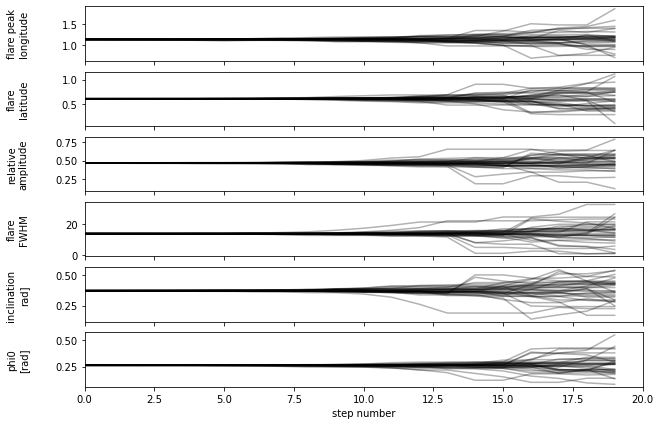

In [11]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['flare peak\nlongitude', 'flare\nlatitude', 'relative\namplitude', 'flare\nFWHM', 'inclination \nrad]', 'phi0\n[rad]']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.savefig("mock_sample_sigi_i.001.png",dpi=300)

In [ ]:

flat_samples = sampler.get_chain(discard=1, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths=[phi_a, theta_a, a, fwhm,i, phi0]);
#plt.savefig("corner_mock_sample_sigi_i.001.png",dpi=300)

In [ ]:
.61/np.pi*180-.69/np.pi*180 #pm 10

In [ ]:
inds = np.random.randint(len(flat_samples), size=1500)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(phi, flux, s=10, c="k")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a, fwhm, a = sample[[0,3,2]]
    plt.plot(phi, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=14)
plt.xlabel("time")
plt.ylabel("flux");
#plt.savefig("fit_mock_sample_sigi_i.001.png",dpi=300)

In [ ]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc, c, d, e = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

In [ ]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [ ]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [ ]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [ ]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [ ]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

In [ ]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)